# Game of Life (infinite plane)

*Author*: **qpxu007@gmail.com**

[Conway's game of life (GOL)](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) is well-known cellular automata that demonstrates simple rules can generate complicated and interesting patterns. The rules are as following:

The game universe is a plane consists of rectangle cells. Each cell can be dead (value 0) or alive (value 1). The status of the cell are updated from generation to generation, and the status of a cell in the following generate is determined by its 8 neigbhors in its previous generation: 

1. Any live cell with fewer than two live neighbors dies (underpopulation). 
2. Any live cell with more than three live neighbors dies (overcrowding). 
3. Any live cell with two or three live neighbors lives on to the next generation.
4. Any dead cell with exactly three live neighbors becomes a live cell (offsprings).

Games of life is often implemented in using two dimensional arrays, which are used to store value (0 or 1) of each cell. Here we explore implementation of GOL under different boundary conditions.

## Displaying matrix

First, we can write code to display the results more nicely. We can use matplotlib to plot it (live cells in black):

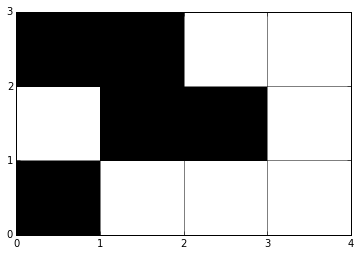

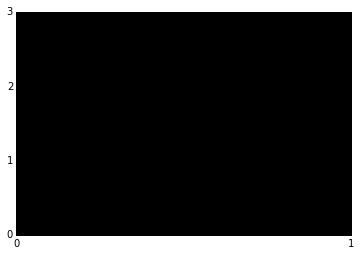

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl

%matplotlib inline  

def plotcells(array):
    m = len(array)
    n = len(array[0])
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    if not n:
        # empty matrix, plot one white square
        ax.add_patch(patches.Rectangle((0,0), 1,1, color="white"))
        plt.xlim(0, 1)
        plt.ylim(0, 1)
    else:
        for i, row in enumerate(array):
            for j, cell in enumerate(row):
                if cell:
                    ax.add_patch(patches.Rectangle((j,i), 1,1, color="black"))
                else: 
                    ax.add_patch(patches.Rectangle((j,i), 1,1, color="white"))

        plt.xlim(0, n)
        plt.ylim(0, m)

    tick_spacing = max(m,n)//10+1
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(tick_spacing))
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(tick_spacing))


    plt.grid(True, color = 'black', linestyle = '-')

    plt.show()

mat = [[1,0,0,0], [0,1,1,0], [1,1,0,0]]
plotcells(mat)     
plotcells([[1],[1],[1]])

## Random configuration generation

We we use numpy to generate some random matrix, given dimension of the matrix (row, col) and precentage of cells 
with values of 1.

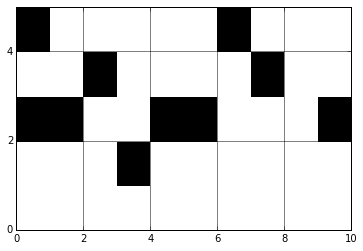

In [28]:
import numpy as np

def generate_start_config(m=1, n=1, p=0.5, seed=1):
    """Generate a starting matrix given number of rows and columns, percentage of live cells, and seed"""
    np.random.seed(seed)
    cells = np.random.choice(2,m*n,p=[1-p,p])
    return cells.reshape(m,n)

plotcells(generate_start_config(5,10,0.2))

## Fixed-size universe

If we assume the plane is of finite size (m x n), it is straightforward to implement GOL using matrix in python:

In [29]:
def neighbor_list(index, m, n):
    ''' given a cell position (a tuple) and cell dimensions, return a list of indices of valid cells '''
    x, y = index
    nxy = lambda x, y: [(x - 1, y - 1), (x - 1, y), (x - 1, y + 1), (x, y - 1), (x, y + 1), (x + 1, y - 1), (x + 1, y),
                        (x + 1, y + 1)]
    valid_pix = lambda x, y, m, n: 0 <= x <= m - 1 and 0 <= y <= n - 1
    return [(a, b) for a, b in nxy(x, y) if valid_pix(a, b, m, n)]


def update_by_rule(value, live_neighbours):
    ''' give a value and its number of live neighbors, return a new value based on a set of rules    '''
    if value == 1:
        # under population or overpopulation
        if live_neighbours < 2 or live_neighbours > 3:
            return 0
        else:
            return 1
    # offspring
    if value == 0 and live_neighbours == 3:
        return 1
    return value


def count_live_neighbors(cells, indices):
    """ sum up the cell values for given indices (given as tuples) """
    return sum(cells[i][j] for i, j in indices)


def one_generation_matrix(cells):
    """ one generation of evolution by rule """
    m = len(cells)  # mrows
    n = len(cells[0])  # ncols
    new_cells = [[0] * n for _ in range(m)]
    for i in xrange(m):
        for j in xrange(n):
            nlive_neighbors = count_live_neighbors(cells, neighbor_list((i, j), m, n))
            new_cells[i][j] = update_by_rule(cells[i][j], nlive_neighbors)
    return new_cells


def get_generation(cells, generations):
    for _ in xrange(generations):
        cells = one_generation(cells)
    return cells

For a simple test case of a 3x3 unit matrix, after 1 generation of evolution, we get:

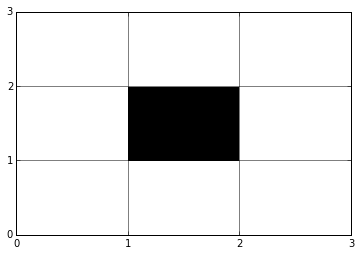

In [30]:
start = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
plotcells(one_generation_matrix(start))

## Periodic boundary condition

Now what if we have a periodic condition? In other words, the plane consists of infinite numbers of 
fixed planes that are related by periodic translations. For example, the (-1, -1) cell in above figure is equivalent to 
the (2, 2) cell. As a result, if a neighbor cell is outside the bound, we can always find an equvalent cell inside 
by a modulus operation. As a result, we need to modify the neighbor_list function to incorporate this case.

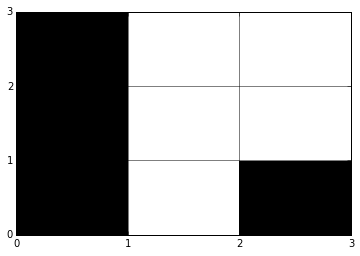

In [31]:
def neighbor_list(index, m, n, mode='periodic'):
    """ given a cell position (a tuple) and cell dimensions, return a list of indices of valid cells, 
    based on boundary condition """
    x, y = index
    nxy = lambda x, y: [(x - 1, y - 1), (x - 1, y), (x - 1, y + 1), 
                        (x, y - 1), (x, y + 1), (x + 1, y - 1), (x + 1, y),
                        (x + 1, y + 1)]
    if mode == 'periodic':
        return [(i % m, j % n) for i,j in nxy(x,y)]
    elif mode == 'fixed': 
        valid_pix = lambda x, y, m, n: 0 <= x <= m - 1 and 0 <= y <= n - 1
        return [(a, b) for a, b in nxy(x, y) if valid_pix(a, b, m, n)]
    else:
        print "undefined mode"
        return None

start = [[1, 0, 1], [1, 0, 0], [1, 0, 0]]
plotcells(one_generation_matrix(start))

## Animating results

First we modify the plotcells function such that it write to a image file for a given matrix data.

In [32]:
def cells2png(array, seq):
    m = len(array)
    n = len(array[0])
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    if not n:
        # empty matrix, plot one white square
        ax.add_patch(patches.Rectangle((0,0), 1,1, color="white"))
        plt.xlim(0, 1)
        plt.ylim(0, 1)
    else:
        for i, row in enumerate(array):
            for j, cell in enumerate(row):
                if cell:
                    ax.add_patch(patches.Rectangle((j,i), 1,1, color="black"))
                else: 
                    ax.add_patch(patches.Rectangle((j,i), 1,1, color="white"))

        plt.xlim(0, n)
        plt.ylim(0, m)

    tick_spacing = max(m,n)//10+1
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(tick_spacing))
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(tick_spacing))
    plt.grid(True, color = 'black', linestyle = '-')
    
    file_prefix = 'GOL'
    plt.savefig(file_prefix + '-img-' + str(seq).zfill(3) + '.png', bbox_inches='tight')
    plt.close(fig)

Now we can create a 20x20 with 50% randomly distributed live cells, evolve it for 200 steps using periodic boundary condition, and produce an animated gif. We save the results of each step into a png image, then we use the write2Gif function from images2gif module to combine the sequence of images into an animated gif.   

In [33]:
##  Now let us generate some data   
cells = generate_start_config(20,20)

cells_multigen = list()
ngen = 200

# create a sequence of images, each representing a generation
for i in xrange(ngen):
    cells2png(cells, i)
    cells = one_generation_matrix(cells)
else: 
    print "done evolution"

# generating animated gif
import IPython.display as IPdisplay
import glob
from PIL import Image
from images2gif import writeGif

images = [Image.open(image) for image in glob.glob('GOL-*.png')]
writeGif("GOL-animation-001.gif", images, duration=0.4)
IPdisplay.Image(url="GOL-animation-001.gif")

done evolution


## Infinite plane (no boundary condition)

However, if the plane is infinite, what will happen then? Image a case with three consecutive cells on the border, for example as shown below:

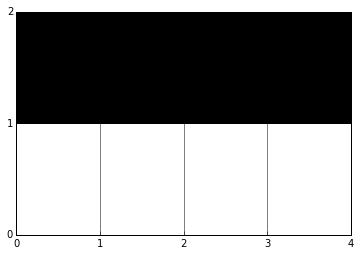

In [34]:
plotcells([[0,0,0,0],[1,1,1,1]])

New cells will become alive at (1,2) and (2,2) positions in the next generation. In other words, the next generation will occupy 
some new territory. On the other hand, the updates for current live cells will not change since those new cells 
will all assmed to be dead.

Thus, for the matrix implementation, we would need to manange the shape of the matrix dynamically to accomondate new cells next to the current border that may become alive (note that the matrix can at most expand by one column/row in each direction between two consecutive generations, as dictated by how we define neighbors). Here, we will consider a different representation of the data. Instead of using a matrix, we save the coordinates (x,y) of all live cells as a list of tuples. This has at least two advantages:

1. we don't need to consider the boundary explicitly, (x,y) position tuples can have negative values
2. our calculation will only revolve around those live cells, we only need to check
    - live cells
    - neighbors of the live cells that are current dead

First, we will need some functions to convert the matrix into list of tuples, or visa versa

In [35]:
def mat2tuples(cells):
    """ Given cells represented in a matrix, return a list of positions (i,j) with live cells"""
    return [(i, j) for i, row in enumerate(cells) for j, col in enumerate(row) if col]

def tuples2mat(tuples):
    """ Given positions of live cells (as x,y tuples), convert them in a minimum matrix representation"""
    if not tuples:
        return [[]]

    (xmin, xmax), (ymin, ymax) = xylim(tuples)
    ny = ymax - ymin + 1
    nx = xmax - xmin + 1
    mat = [[0]*ny for _ in range(nx)]
    for t in tuples:
        x = t[0] - xmin
        y = t[1] - ymin
        mat[x][y] = 1
    return mat


def xylim(tuples):
    """ Given positions of cells, find the minimum rectangle to cover those cells, represented by
    [(xmin,ymin), (xmax, ymax)]
    """
    # assume random ordering of tuples, otherwise, sort by y is not needed
    tuples_sorty = sorted(tuples, key=lambda x: x[1])
    ymin = tuples_sorty[0][1]
    ymax = tuples_sorty[-1][1]

    tuples_sortx = sorted(tuples, key=lambda x: x[0])
    xmin = tuples_sortx[0][0]
    xmax = tuples_sortx[-1][0]
    return [(xmin, xmax), (ymin, ymax)]

print xylim([(5,6), (1,2), (6,2), (1,3)])
mat = [[1, 0, 1], [1, 0, 0], [1, 0, 0]]
tuples = mat2tuples(mat)
mat2 = tuples2mat(tuples)
assert (mat2 == mat)
print "matrix representation = ", mat2
print "tuples representation = ", tuples

[(1, 6), (2, 6)]
matrix representation =  [[1, 0, 1], [1, 0, 0], [1, 0, 0]]
tuples representation =  [(0, 0), (0, 2), (1, 0), (2, 0)]


Now we can implement GOL with no boundary condition, 

In [36]:
def get_neighbors(t):
    x, y = t
    return [(x - 1, y - 1), (x - 1, y), (x - 1, y + 1),
            (x, y - 1), (x, y + 1), (x + 1, y - 1),
            (x + 1, y), (x + 1, y + 1)]


def count_live_neighbors(position_tuple, all_live_tuples):
    """ given a tuple, count how many its neighbors are alive  """
    return len(set(get_neighbors(position_tuple)) & set(all_live_tuples))


def one_generation(all_live_tuples):
    """ one generation of evolution by rule """
    if not all_live_tuples:
        return []

    # pass 1 check all live cells in current generation, and collect all neighboring dead cells
    new_gen = list()
    dead_neighbor_cells = list()
    for cell in all_live_tuples:
        dead_neighbor_cells.extend([t for t in get_neighbors(cell) if t not in all_live_tuples])
        if 2 <= count_live_neighbors(cell, all_live_tuples) <= 3:
            new_gen.append(cell)

    # pass 2, check dead cells adjacent to current live cells
    for cell in set(dead_neighbor_cells):
        if count_live_neighbors(cell, all_live_tuples) == 3:
            new_gen.append(cell)

    # order the output by y, then by x
    return sorted(new_gen, key=lambda x: (x[1], x[0]))


def evolve(all_live_tuples, generations):
    """ evolve a specific generations """
    curr = all_live_tuples
    for _ in range(generations):
        curr = one_generation(curr)
    return curr


def get_generation(cells, generations):
    """ Provide matrix interface to call """
    tuples = mat2tuples(cells)
    new_gen = evolve(tuples, generations)
    return tuples2mat(new_gen)

Most of the work is done in the one_generation function. In first pass, we go through all live cells, and for each,  and count number of its neighbors to decide whether it will stay alive (save into a new list of live tuples). Additionally, we collect the neighboring dead cells of these live cells (duplicates are removed by using a set).  In the second pass, we check the number of live neighbors for each distinct dead cell adjacent to the live cells, and add them to the new live list if it meets the condition to become alive (i.e. number of live neighbors is 3). 

For test case [[1,1,1]], we expect that the three 1's rotate 90 degree between generations:

In [37]:
print get_generation([[1,1,1]],1)
print get_generation([[1,1,1]],2)

[[1], [1], [1]]
[[1, 1, 1]]


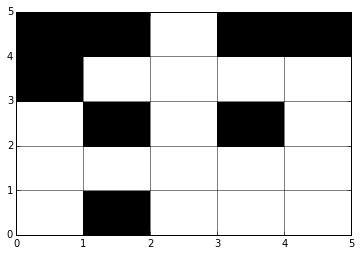

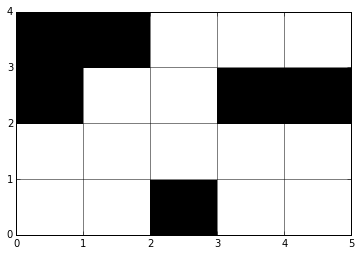

In [38]:
mat = generate_start_config(5,5,0.4)
plotcells(mat)
plotcells(get_generation(mat,1))

## Putting it together

## Simulation

## GOL and edge detection